In [1]:
import sys
from pathlib import Path
import torch

# Přidání prarodiče aktuálního adresáře do sys.path
grandparent = Path().resolve().parent.parent
sys.path.append(grandparent)

from utils import SegmentsHandler
from source_data.tweetynet.Inc.segments_handler import VisualizationHandler

sys.path.append('model')
from model.UNetHandler import UNet, load_config
from model.DataHandler import BirdUNetDataset
from utils import Log, Visualization

PRINT = Log.get_logger()

CONFIG = load_config('config.json')
MEAN = CONFIG['data']['augmentation'].get('normalization_mean')
STD = CONFIG['data']['augmentation'].get('normalization_std')

dataset = BirdUNetDataset(None, None,
                          transform_attrs={'mean': MEAN, 'std': STD}, debug=True)

model = UNet(in_channels=1, num_classes=2, DataHandler=dataset)

model.load_weights('model_weights.pth')
    
def inference(time_bins, frequency_bins, spectrum, bin_size):
    
        segments = SegmentsHandler.crop_spectrogram(spectrum, time_bins, crop_size=bin_size)

        outputs = []
        for segment in segments:
            predicted_mask = model.inference(
                {
                    'spectrum_values': segment['spectrum'],
                    'time_bins': segment['time_bins'],
                    'freq_bins': frequency_bins
                }
            )

            outputs.append(predicted_mask)

        output_full = torch.cat([segment['mask_values'] for segment in outputs], dim=2)

        original_time_lenght = time_bins.shape[0]
        output_original_length = output_full[:, :, :original_time_lenght]

        image_PIL = Visualization.spectrum_above_mask(spectrum=torch.tensor(spectrum),
                                        mask=output_original_length.squeeze(0),
                                        frequency_bins=frequency_bins,
                                        time_bins=time_bins, output_mode='return')

        image_PIL.show()
        return time_bins, frequency_bins, spectrum, outputs

/Users/vojtechremis/Desktop/Projects/birdsong-segmentation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


23:53:59	__ERROR__: During WANDB engine initialization following error occurred: expected str, bytes or os.PathLike object, not NoneType


# dokázat croppnout spektrogramový segment před tím, než půjde do inference
# po predikci rozhodnout, kde jsou segmenty
# segmenty protáhnout až do "stropu"

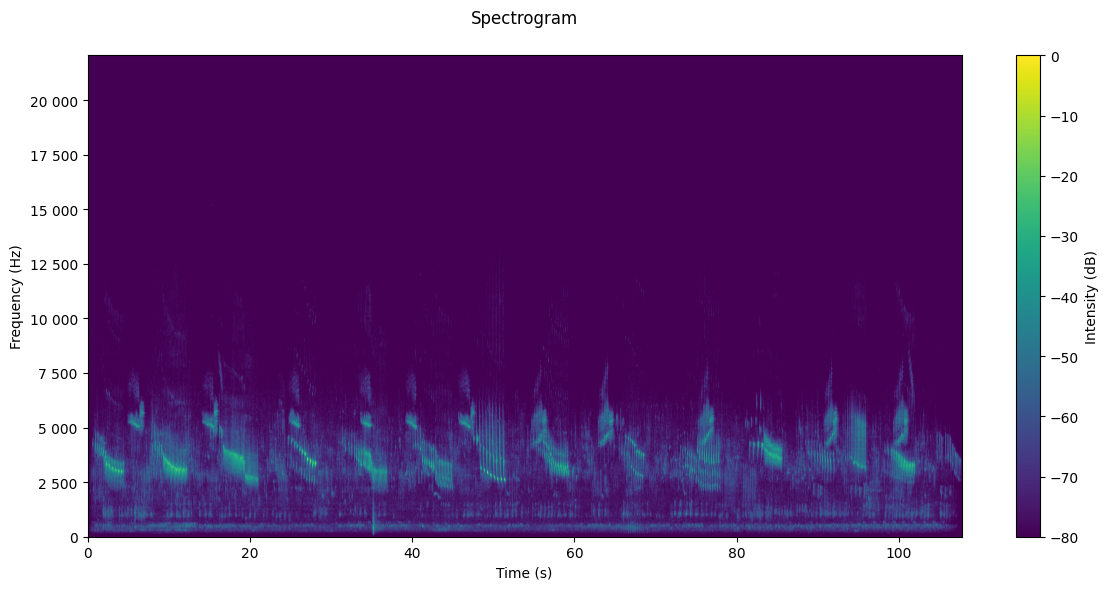

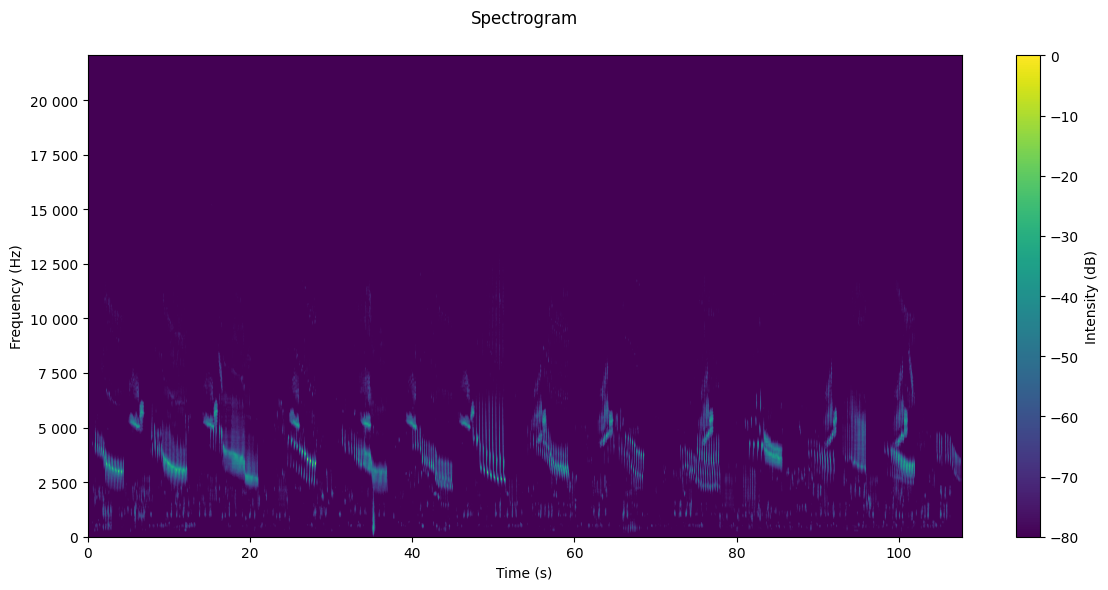

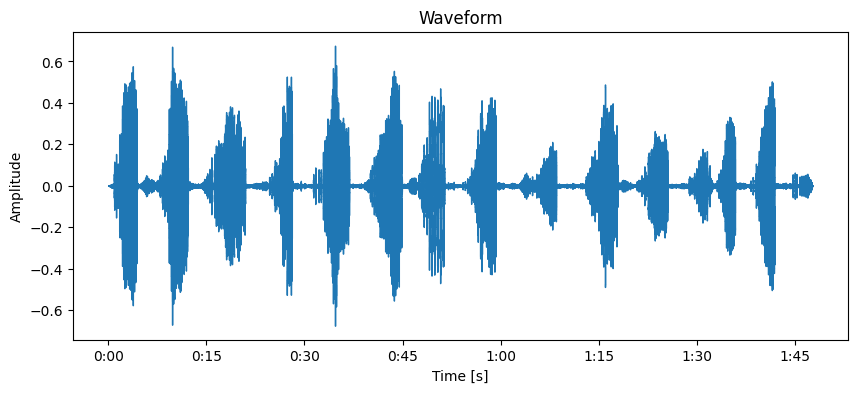

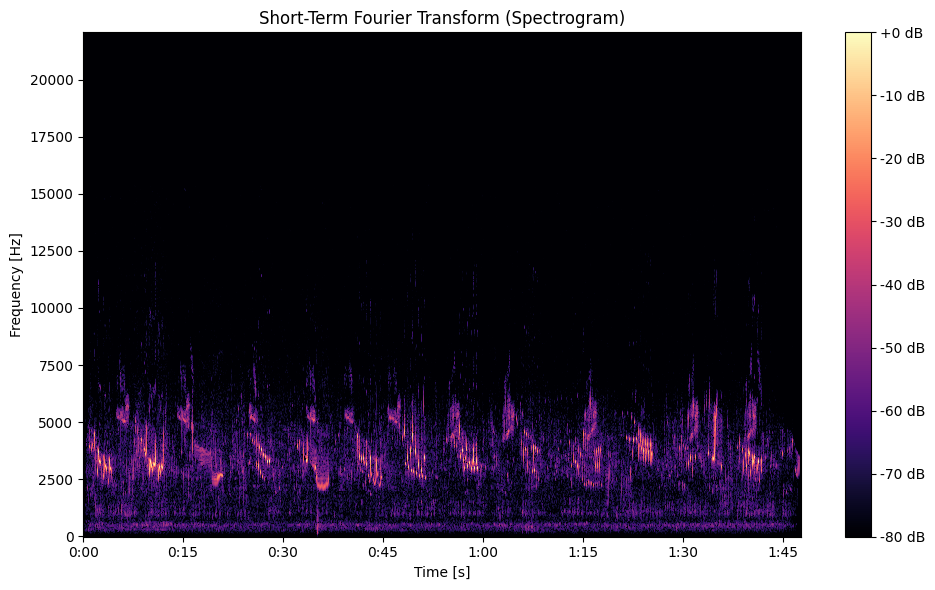

(array([0.00000000e+00, 2.69841270e-03, 5.39682540e-03, ...,
        1.07696349e+02, 1.07699048e+02, 1.07701746e+02]),
 array([   0.        ,   43.06640625,   86.1328125 ,  129.19921875,
         172.265625  ,  215.33203125,  258.3984375 ,  301.46484375,
         344.53125   ,  387.59765625,  430.6640625 ,  473.73046875,
         516.796875  ,  559.86328125,  602.9296875 ,  645.99609375,
         689.0625    ,  732.12890625,  775.1953125 ,  818.26171875,
         861.328125  ,  904.39453125,  947.4609375 ,  990.52734375,
        1033.59375   , 1076.66015625, 1119.7265625 , 1162.79296875,
        1205.859375  , 1248.92578125, 1291.9921875 , 1335.05859375,
        1378.125     , 1421.19140625, 1464.2578125 , 1507.32421875,
        1550.390625  , 1593.45703125, 1636.5234375 , 1679.58984375,
        1722.65625   , 1765.72265625, 1808.7890625 , 1851.85546875,
        1894.921875  , 1937.98828125, 1981.0546875 , 2024.12109375,
        2067.1875    , 2110.25390625, 2153.3203125 , 2196.3867187

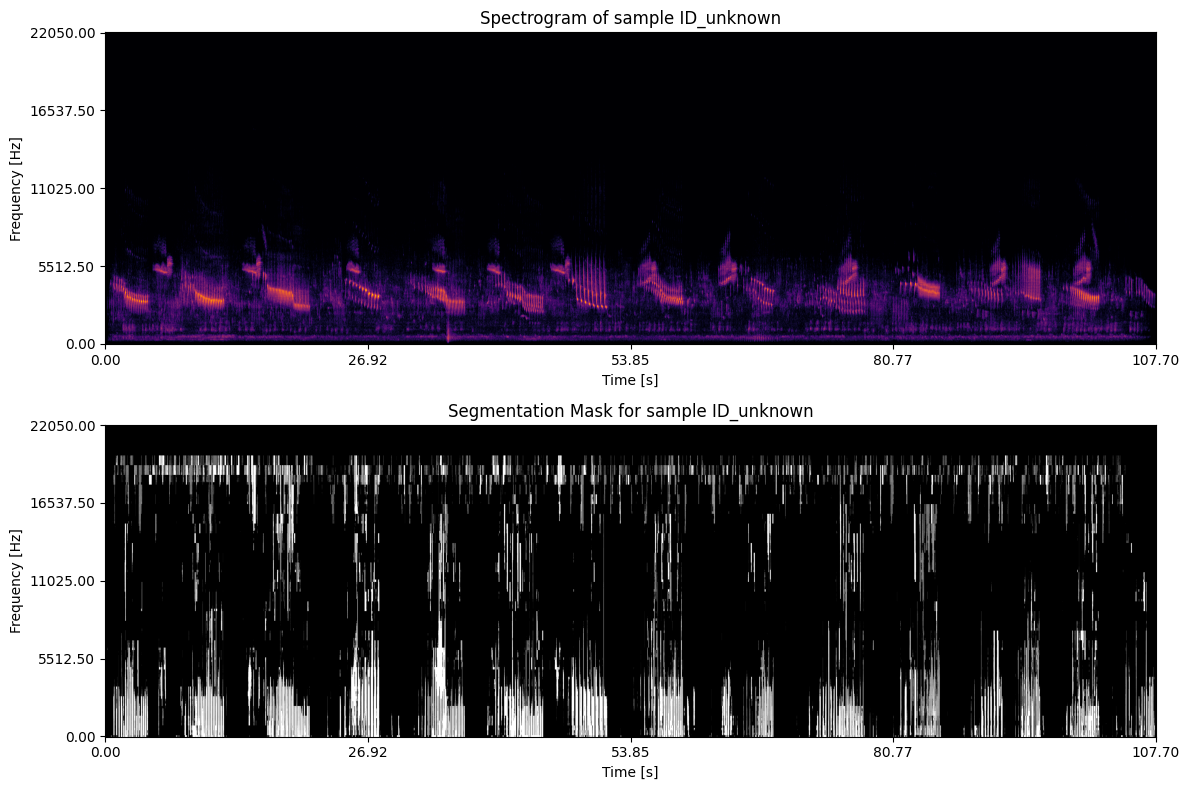

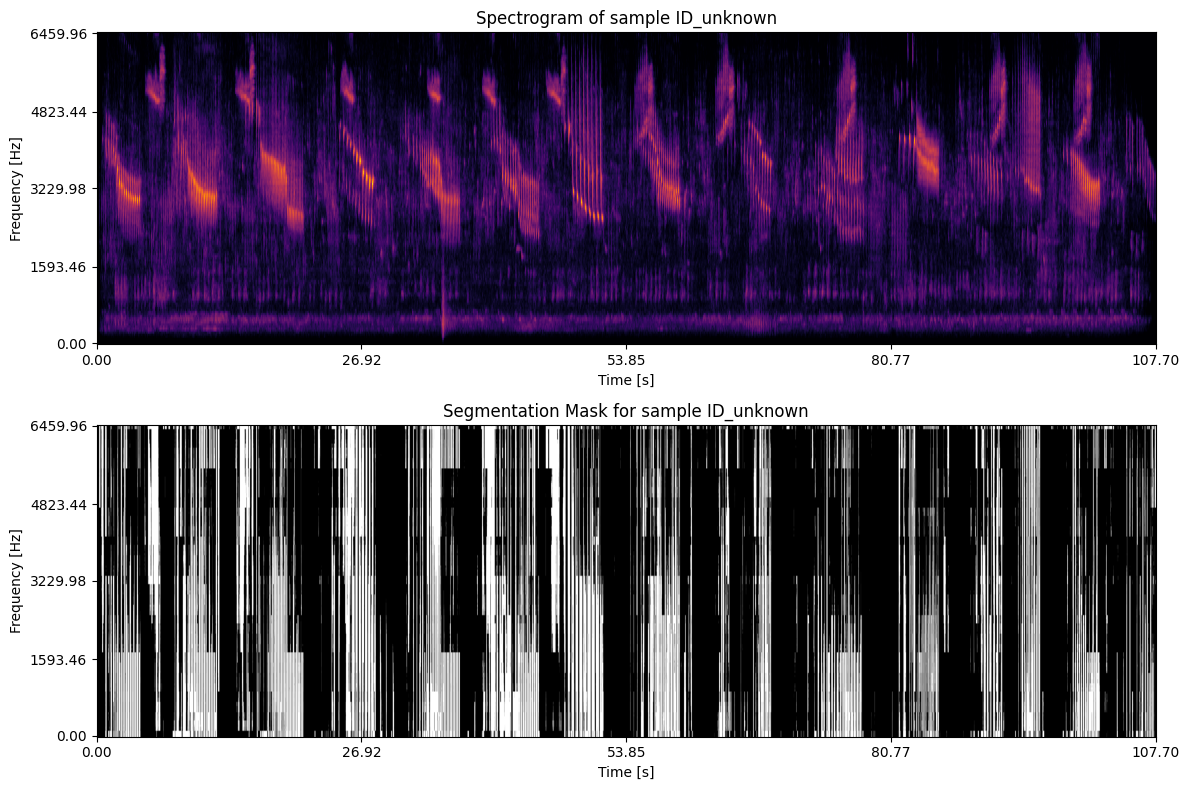

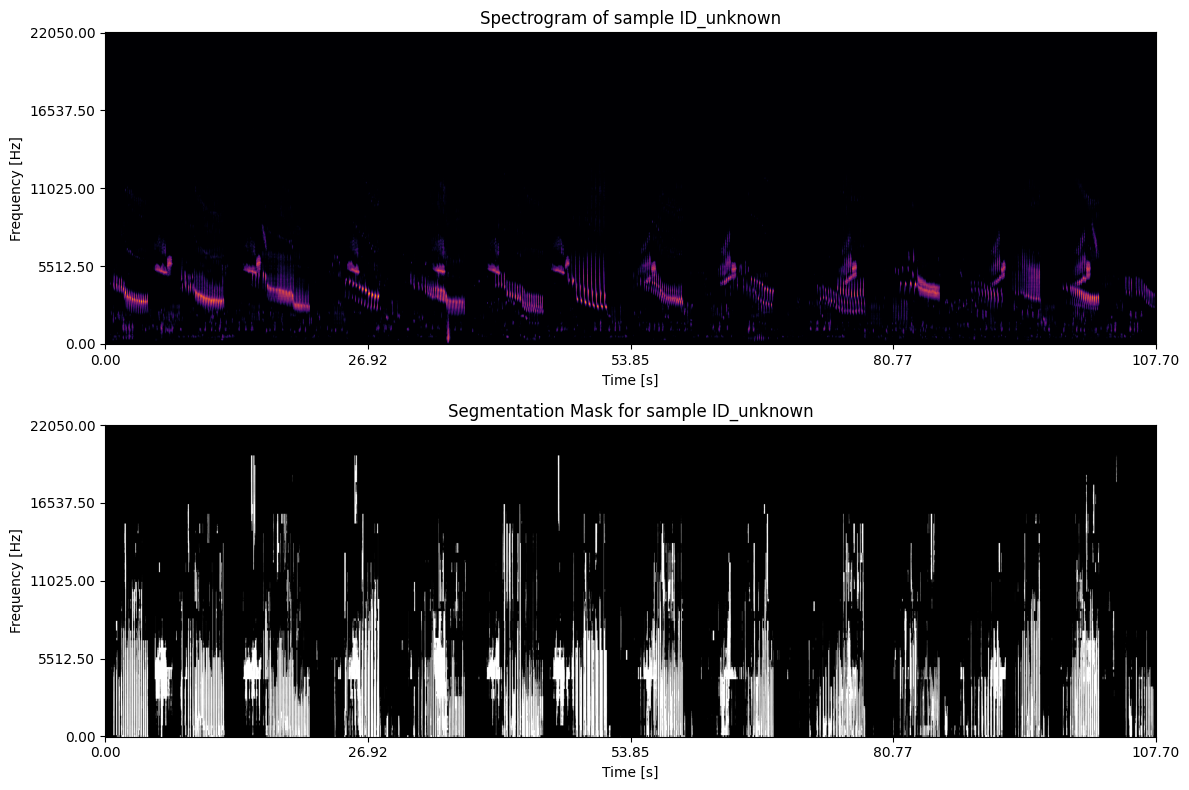

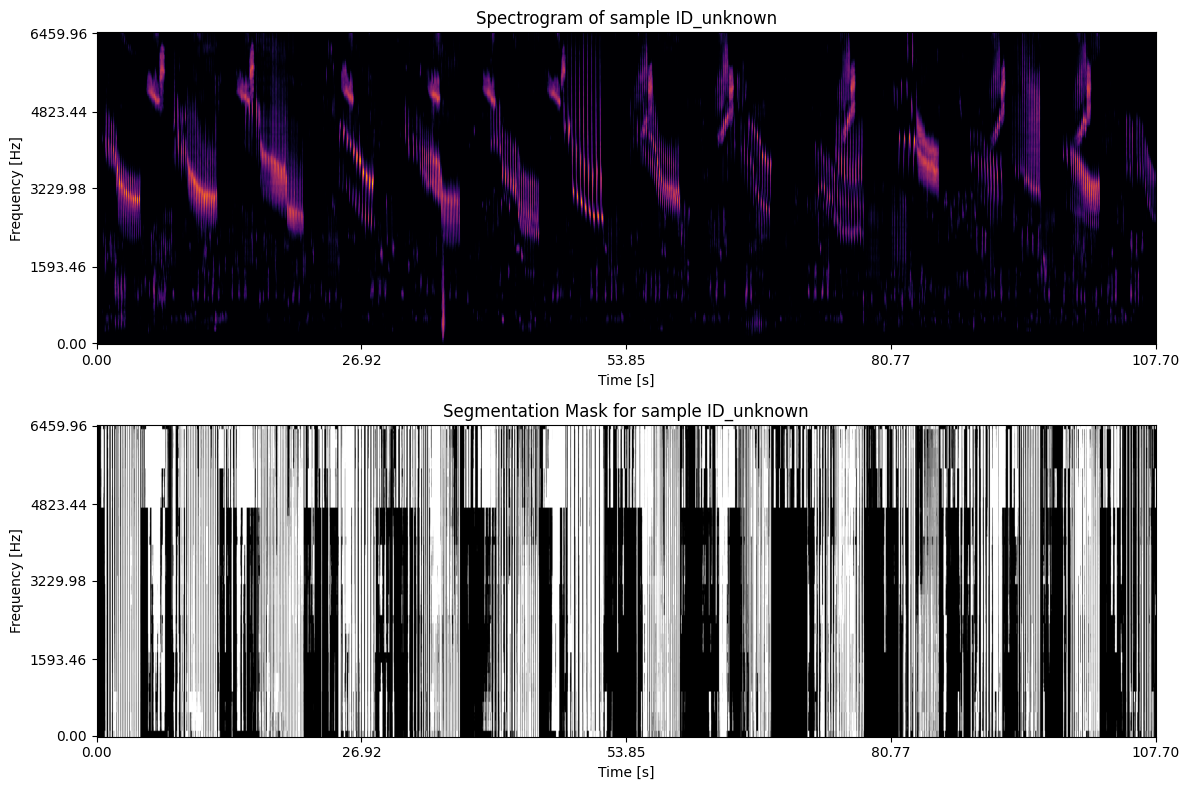

In [6]:
import noisereduce as nr
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

VH = VisualizationHandler()

def plot_fft_spectrogram(signal, sr, title):
    """
    Zobrazí FFT spektrogram signálu.
    
    Parametry:
    - signal: Zvukový signál (numpy array).
    - sr: Vzorkovací frekvence (sample rate).
    - title: Název grafu.
    """
    # Vypočítání Short-Time Fourier Transform (STFT)
    stft = librosa.stft(signal)
    amplitute = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    # Vykreslení
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(amplitute, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Čas (s)")
    plt.ylabel("Frekvence (Hz)")
    plt.show()

def reduce_noise_and_plot(input_file, noise_start=0, noise_duration=1, NFFT=1024, hop_length=119):
    """
    Redukce šumu a zobrazení FFT spektrogramů před a po.
    
    Parametry:
    - input_file: Cesta k původnímu zvukovému souboru.
    - output_file: Cesta pro uložení upraveného zvuku.
    - noise_start: Čas (v sekundách), kdy začíná šumový profil.
    - noise_duration: Délka šumu (v sekundách).
    """
    # Načtení audio souboru
    y, sr = librosa.load(input_file, sr=None)

    # Spektrogram před odstraněním šumu
    time_bins, frequency_bins, spectrum = SegmentsHandler.calculate_spectrogram(y, sr)
    VH.plot_spectrogram(time_bins, frequency_bins, spectrum)
    
    
    # Výběr šumového profilu
    noise_sample_start = int(noise_start * sr)
    noise_sample_end = int((noise_start + noise_duration) * sr)
    noise_profile = y[noise_sample_start:noise_sample_end]

    # Redukce šumu
    reduced_noise = nr.reduce_noise(y=y, sr=sr, y_noise=noise_profile)

    # Spektrogram po odstranění šumu
    time_bins, frequency_bins, spectrum = SegmentsHandler.calculate_spectrogram(reduced_noise, sr)
    
    VH.plot_spectrogram(time_bins, frequency_bins, spectrum)
    
    return time_bins, frequency_bins, spectrum
    


# Použití
input_file = "/Users/vojtechremis/Desktop/Projects/birdsong-segmentation/source_data/xeno-canto/Song_files/146811_Lullula_arborea.mp3"    # Nahraďte cestou ke svému zvukovému souboru
times, frequencies, spectrogram_clean = reduce_noise_and_plot(input_file, noise_start=0, noise_duration=2)

time_bins, frequency_bins, spectrum, y = SegmentsHandler.load_birdsong(input_file)
inference(times, frequencies, spectrum, 128)
inference(times, frequencies[:151], spectrum[:151, :], 128)
inference(times, frequencies, spectrogram_clean, 128)
inference(times, frequencies[:151], spectrogram_clean[:151, :], 128)




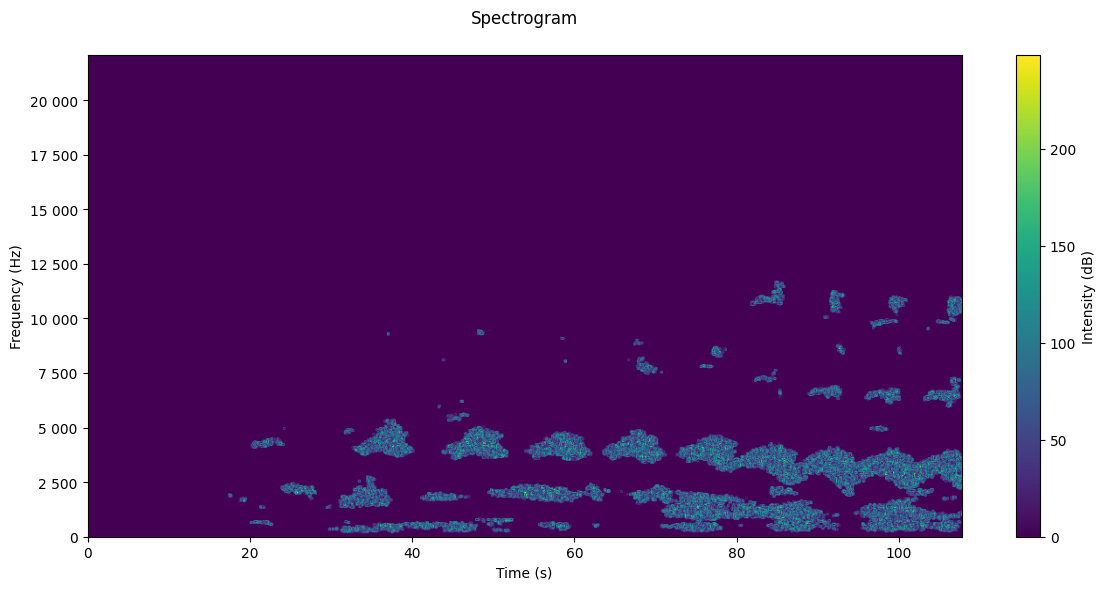

Počet řádků, které lze odříznout shora: 3


In [17]:
import cv2

# Předpokládáme, že spectrogram_clean je již vypočítaný spektrogram
# Ujistěte se, že spektrogram má hodnoty vhodné pro zpracování (např. 0-255 nebo float32)

# Pokud má spektrogram float hodnoty, normalizujte ho na rozsah 0-255
if spectrogram_clean.max() > 1.0:
    spectrogram_normalized = (spectrogram_clean - spectrogram_clean.min()) / (spectrogram_clean.max() - spectrogram_clean.min())
    spectrogram_normalized = (spectrogram_normalized * 255).astype(np.uint8)
else:
    spectrogram_normalized = (spectrogram_clean * 255).astype(np.uint8)

# Aplikace Sobelova filtru
sobel_x = cv2.Sobel(spectrogram_normalized, cv2.CV_64F, 1, 0, ksize=3)  # Detekce hran ve směru X
sobel_y = cv2.Sobel(spectrogram_normalized, cv2.CV_64F, 0, 1, ksize=3)  # Detekce hran ve směru Y

# Kombinace hran
sobel_combined = cv2.magnitude(sobel_x, sobel_y)  # Vypočítej velikost gradientu

# Normalizace výsledného obrázku
sobel_combined = np.uint8(255 * sobel_combined / np.max(sobel_combined))

# Zobrazení výsledků
VH.plot_spectrogram(time_bins, frequency_bins, sobel_combined[:, :1000])

height, width = sobel_combined.shape

# Práh pro téměř žádné hrany (např. méně než 1 % šířky obrázku)
threshold = int(width * 0.01)

# Spočítat počet hran v každém řádku
edge_counts = np.sum(sobel_combined > 0, axis=1)  # Počet nenulových pixelů pro každý řádek

# Najít poslední řádek, kde počet hran je pod prahem
cutoff_row = 0
for i, count in enumerate(edge_counts):
    if count > threshold:
        break  # Jakmile najdeme první řádek, který překračuje práh, zastavíme
    cutoff_row = i

print(f"Počet řádků, které lze odříznout shora: {cutoff_row}")